In [1]:
# importanto bibliotecas
import pandas as pd
import numpy as np
import psycopg2

#pacotes gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#importando bibliotecas estatísticas
import scipy.stats as stats

In [2]:
# conexão redshift 
connection = psycopg2.connect(dbname="dw_amorsaude",

                  user="lucasmateus",

                  password="df93aS@aK0sd",

                  host ="amorsaude-cluster-redshift.cmc4ev2oyczd.us-east-1.redshift.amazonaws.com",

                  port = 5439)

In [3]:
# definindo query
query = """
select 
	cp.datapagamento,
	cp.id,
	cp.nome_fantasia nome_unidade,
	case when cp.subcategoria in ('Royalties','Royalties (Split)') then 'Royalties' 
	     else cp.categoria end categoria,
	cp.subcategoria,
	cp.valorpago
from tb_consolidacao_contas_a_pagar_hist cp
where cp.situacaoconta <> 'Em aberto'
and cp.datapagamento <= current_date
order by cp.datapagamento"""

In [4]:
# setando o df
df = pd.read_sql_query(query,con=connection)
df

/tmp/ipykernel_28921/3854971275.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query,con=connection)


,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago
0,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Folha Mensal - Salário,1301.0
1,2021-01-01,19566.0,AmorSaúde Araçatuba,Funcionários,Folha Mensal - Salário,300.0
2,2021-01-01,19321.0,AmorSaúde Dourados,Despesas com Outros Profissionais,Despesas com Outros Profissionais,361.7
3,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Vale Alimentação/Refeição,220.0
4,2021-01-01,19566.0,AmorSaúde Araçatuba,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,58.0
...,...,...,...,...,...,...
5166634,2023-08-22,19573.0,AmorSaúde João Pessoa Sul,Repasses,Repasse de Consultas,350.0
5166635,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,200.0
5166636,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1225.0
5166637,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1645.0


criar estatística descritiva dos valores nulos

In [5]:
df.isna().mean()*100

datapagamento     0.000000
id                0.064084
nome_unidade      0.064084
categoria         2.575117
subcategoria     51.856768
valorpago         0.000000
dtype: float64

In [6]:
df_null = df[df['categoria'].isna() | df['subcategoria'].isna()]
df_null

,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago
13,2021-01-01,19358.0,AmorSaúde São Leopoldo,Repasses,None,58000.00
16,2021-01-01,19626.0,AmorSaúde Porto Velho,None,None,150.00
20,2021-01-01,19626.0,AmorSaúde Porto Velho,None,None,200.00
26,2021-01-02,19563.0,AmorSaúde RJ Campo Grande,Repasse de Consultas,None,450.00
27,2021-01-02,19289.0,AmorSaúde Franco da Rocha,Repasses,None,420.00
...,...,...,...,...,...,...
5166577,2023-08-22,19969.0,AmorSaúde Porto Alegre Centro,Repasses,None,528.00
5166597,2023-08-22,19324.0,AmorSaúde Praia Grande,Repasses,None,447.15
5166618,2023-08-22,19947.0,AmorSaúde Guarujá,Despesas com Médicos,None,70.00
5166622,2023-08-22,19969.0,AmorSaúde Porto Alegre Centro,Repasses,None,260.00


In [7]:
#executar testes para as despesas com subcategoria null

In [8]:
df = df.dropna()

Análise de outliers de despesas através do método IQR

In [9]:
df.columns

Index(['datapagamento', 'id', 'nome_unidade', 'categoria', 'subcategoria',
       'valorpago'],
      dtype='object')

In [10]:
df_batatais = df.loc[(df['id']==19957) & (df['subcategoria']=='Folha Mensal - Adiantamento')]
len(df_batatais)

31

In [11]:
# Calculate quartiles using the groupby and agg functions for each quartile
q1_df = df.groupby(['id', 'nome_unidade', 'categoria', 'subcategoria'])['valorpago'].quantile(0.25).reset_index()
median_df = df.groupby(['id', 'nome_unidade', 'categoria', 'subcategoria'])['valorpago'].median().reset_index()
q3_df = df.groupby(['id', 'nome_unidade', 'categoria', 'subcategoria'])['valorpago'].quantile(0.75).reset_index()

# Rename columns to reflect the quartiles
q1_df.rename(columns={'valorpago': 'Q1'}, inplace=True)
median_df.rename(columns={'valorpago': 'median'}, inplace=True)
q3_df.rename(columns={'valorpago': 'Q3'}, inplace=True)

# Merge the quartile DataFrames to create the final result
quartiles_df = q1_df.merge(median_df, on=['id', 'nome_unidade', 'categoria', 'subcategoria']).merge(q3_df, on=['id', 'nome_unidade', 'categoria', 'subcategoria'])

quartiles_df

,id,nome_unidade,categoria,subcategoria,Q1,median,Q3
0,0.0,CENTRAL AMORSAÚDE,Funcionários,Vale Transporte,1315.2000,1315.20,1315.2000
1,18263.0,AmorSaúde Carapicuíba,Administrativas,Advogados,2044.4500,2044.45,2044.4500
2,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel Imóvel,600.0000,857.58,7995.6000
3,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel de Equipamentos,600.0000,900.59,2790.0000
4,18263.0,AmorSaúde Carapicuíba,Administrativas,Alvarás,240.6400,698.00,803.1275
...,...,...,...,...,...,...,...
33923,19990.0,AmorSaúde Piracicaba Vila Sônia,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,143.7500,234.50,325.2500
33924,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Consultas,420.0000,500.00,600.0000
33925,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Procedimentos,60.0000,155.00,261.5000
33926,19990.0,AmorSaúde Piracicaba Vila Sônia,Sócios,Transação Entre Contas Médica e Odonto,283.7175,1909.98,3590.7150


In [12]:
quartiles_df['IQR'] = (quartiles_df['Q3'] - quartiles_df['Q1'])
quartiles_df

,id,nome_unidade,categoria,subcategoria,Q1,median,Q3,IQR
0,0.0,CENTRAL AMORSAÚDE,Funcionários,Vale Transporte,1315.2000,1315.20,1315.2000,0.0000
1,18263.0,AmorSaúde Carapicuíba,Administrativas,Advogados,2044.4500,2044.45,2044.4500,0.0000
2,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel Imóvel,600.0000,857.58,7995.6000,7395.6000
3,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel de Equipamentos,600.0000,900.59,2790.0000,2190.0000
4,18263.0,AmorSaúde Carapicuíba,Administrativas,Alvarás,240.6400,698.00,803.1275,562.4875
...,...,...,...,...,...,...,...,...
33923,19990.0,AmorSaúde Piracicaba Vila Sônia,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,143.7500,234.50,325.2500,181.5000
33924,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Consultas,420.0000,500.00,600.0000,180.0000
33925,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Procedimentos,60.0000,155.00,261.5000,201.5000
33926,19990.0,AmorSaúde Piracicaba Vila Sônia,Sócios,Transação Entre Contas Médica e Odonto,283.7175,1909.98,3590.7150,3306.9975


In [13]:
# Calculate lower and upper fences using IQR
iqr_multiplier = 1.5  # Adjust as needed
quartiles_df['lower_fence'] = quartiles_df['Q1'] - iqr_multiplier * quartiles_df['IQR']
quartiles_df['upper_fence'] = quartiles_df['Q3'] + iqr_multiplier * quartiles_df['IQR']

quartiles_df

,id,nome_unidade,categoria,subcategoria,Q1,median,Q3,IQR,lower_fence,upper_fence
0,0.0,CENTRAL AMORSAÚDE,Funcionários,Vale Transporte,1315.2000,1315.20,1315.2000,0.0000,1315.20000,1315.20000
1,18263.0,AmorSaúde Carapicuíba,Administrativas,Advogados,2044.4500,2044.45,2044.4500,0.0000,2044.45000,2044.45000
2,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel Imóvel,600.0000,857.58,7995.6000,7395.6000,-10493.40000,19089.00000
3,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel de Equipamentos,600.0000,900.59,2790.0000,2190.0000,-2685.00000,6075.00000
4,18263.0,AmorSaúde Carapicuíba,Administrativas,Alvarás,240.6400,698.00,803.1275,562.4875,-603.09125,1646.85875
...,...,...,...,...,...,...,...,...,...,...
33923,19990.0,AmorSaúde Piracicaba Vila Sônia,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,143.7500,234.50,325.2500,181.5000,-128.50000,597.50000
33924,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Consultas,420.0000,500.00,600.0000,180.0000,150.00000,870.00000
33925,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Procedimentos,60.0000,155.00,261.5000,201.5000,-242.25000,563.75000
33926,19990.0,AmorSaúde Piracicaba Vila Sônia,Sócios,Transação Entre Contas Médica e Odonto,283.7175,1909.98,3590.7150,3306.9975,-4676.77875,8551.21125


In [14]:
# Create a new DataFrame df_iqr as a copy of the original df
df_iqr = df.copy()

# Merge df_iqr with quartiles_df based on specified columns
df_iqr = df_iqr.merge(quartiles_df, on=['id', 'nome_unidade', 'categoria', 'subcategoria'], how='left')

df_iqr

,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago,Q1,median,Q3,IQR,lower_fence,upper_fence
0,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Folha Mensal - Salário,1301.0,90.3300,1100.00,1345.06,1254.7300,-1791.76500,3227.15500
1,2021-01-01,19566.0,AmorSaúde Araçatuba,Funcionários,Folha Mensal - Salário,300.0,1253.8325,1371.27,1780.60,526.7675,463.68125,2570.75125
2,2021-01-01,19321.0,AmorSaúde Dourados,Despesas com Outros Profissionais,Despesas com Outros Profissionais,361.7,361.7000,500.00,500.00,138.3000,154.25000,707.45000
3,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Vale Alimentação/Refeição,220.0,49.2500,150.00,210.00,160.7500,-191.87500,451.12500
4,2021-01-01,19566.0,AmorSaúde Araçatuba,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,58.0,35.5000,92.50,160.00,124.5000,-151.25000,346.75000
...,...,...,...,...,...,...,...,...,...,...,...,...
2485890,2023-08-22,19573.0,AmorSaúde João Pessoa Sul,Repasses,Repasse de Consultas,350.0,211.2000,345.60,500.00,288.8000,-222.00000,933.20000
2485891,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,200.0,75.0000,400.00,900.00,825.0000,-1162.50000,2137.50000
2485892,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1225.0,75.0000,400.00,900.00,825.0000,-1162.50000,2137.50000
2485893,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1645.0,75.0000,400.00,900.00,825.0000,-1162.50000,2137.50000


In [15]:
df_iqr['otlr_iqr'] = ((df_iqr['valorpago'] < df_iqr['lower_fence']) | (df_iqr['valorpago'] > df_iqr['upper_fence'])).astype(int)
df_iqr['qtd_lancamentos'] = 1
df_iqr

,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago,Q1,median,Q3,IQR,lower_fence,upper_fence,otlr_iqr,qtd_lancamentos
0,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Folha Mensal - Salário,1301.0,90.3300,1100.00,1345.06,1254.7300,-1791.76500,3227.15500,0,1
1,2021-01-01,19566.0,AmorSaúde Araçatuba,Funcionários,Folha Mensal - Salário,300.0,1253.8325,1371.27,1780.60,526.7675,463.68125,2570.75125,1,1
2,2021-01-01,19321.0,AmorSaúde Dourados,Despesas com Outros Profissionais,Despesas com Outros Profissionais,361.7,361.7000,500.00,500.00,138.3000,154.25000,707.45000,0,1
3,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Vale Alimentação/Refeição,220.0,49.2500,150.00,210.00,160.7500,-191.87500,451.12500,0,1
4,2021-01-01,19566.0,AmorSaúde Araçatuba,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,58.0,35.5000,92.50,160.00,124.5000,-151.25000,346.75000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485890,2023-08-22,19573.0,AmorSaúde João Pessoa Sul,Repasses,Repasse de Consultas,350.0,211.2000,345.60,500.00,288.8000,-222.00000,933.20000,0,1
2485891,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,200.0,75.0000,400.00,900.00,825.0000,-1162.50000,2137.50000,0,1
2485892,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1225.0,75.0000,400.00,900.00,825.0000,-1162.50000,2137.50000,0,1
2485893,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1645.0,75.0000,400.00,900.00,825.0000,-1162.50000,2137.50000,0,1


In [16]:
# Group by and aggregate
grouped_iqr = df_iqr.groupby(['id', 'nome_unidade', 'categoria', 'subcategoria']).agg(
    otlr_iqr=('otlr_iqr', 'sum'),
    qtd_lancamentos=('qtd_lancamentos', 'sum')
).reset_index()

# Calculate the percentage of outliers
grouped_iqr['pct_otlr_iqr'] = grouped_iqr['otlr_iqr'] / grouped_iqr['qtd_lancamentos']

grouped_iqr

,id,nome_unidade,categoria,subcategoria,otlr_iqr,qtd_lancamentos,pct_otlr_iqr
0,0.0,CENTRAL AMORSAÚDE,Funcionários,Vale Transporte,0,2,0.000000
1,18263.0,AmorSaúde Carapicuíba,Administrativas,Advogados,0,1,0.000000
2,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel Imóvel,0,100,0.000000
3,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel de Equipamentos,0,90,0.000000
4,18263.0,AmorSaúde Carapicuíba,Administrativas,Alvarás,0,26,0.000000
...,...,...,...,...,...,...,...
33923,19990.0,AmorSaúde Piracicaba Vila Sônia,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,0,2,0.000000
33924,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Consultas,7,64,0.109375
33925,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Procedimentos,2,30,0.066667
33926,19990.0,AmorSaúde Piracicaba Vila Sônia,Sócios,Transação Entre Contas Médica e Odonto,0,4,0.000000


In [17]:
grouped_iqr.to_excel('validacao_iqr_agrupado.xlsx', index=False)

In [18]:
grouped_iqr = grouped_iqr.drop(labels='qtd_lancamentos', axis=1)
grouped_iqr

,id,nome_unidade,categoria,subcategoria,otlr_iqr,pct_otlr_iqr
0,0.0,CENTRAL AMORSAÚDE,Funcionários,Vale Transporte,0,0.000000
1,18263.0,AmorSaúde Carapicuíba,Administrativas,Advogados,0,0.000000
2,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel Imóvel,0,0.000000
3,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel de Equipamentos,0,0.000000
4,18263.0,AmorSaúde Carapicuíba,Administrativas,Alvarás,0,0.000000
...,...,...,...,...,...,...
33923,19990.0,AmorSaúde Piracicaba Vila Sônia,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,0,0.000000
33924,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Consultas,7,0.109375
33925,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Procedimentos,2,0.066667
33926,19990.0,AmorSaúde Piracicaba Vila Sônia,Sócios,Transação Entre Contas Médica e Odonto,0,0.000000


In [19]:
grouped_iqr_batatais = grouped_iqr.loc[(grouped_iqr['id']==19957) & (grouped_iqr['subcategoria']=='Folha Mensal - Adiantamento')]
grouped_iqr_batatais

,id,nome_unidade,categoria,subcategoria,otlr_iqr,pct_otlr_iqr
33250,19957.0,AmorSaúde Batatais,Funcionários,Folha Mensal - Adiantamento,0,0.0


Análise de outliers de despesas através do método do Z-Score modificado

In [20]:
# obtendo a mediana para cada despesa de cada unidade
df_median = df.groupby(['id', 'nome_unidade', 'categoria', 'subcategoria'])['valorpago'].median().reset_index()
df_median.rename(columns={'valorpago': 'median'}, inplace=True)

df_merge = pd.merge(df, df_median, how='left', on=['id', 'nome_unidade', 'categoria', 'subcategoria'])

In [21]:
df_merge['adiff'] = (df_merge['valorpago'] - df_merge['median']).abs()

df_merge

,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago,median,adiff
0,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Folha Mensal - Salário,1301.0,1100.00,201.00
1,2021-01-01,19566.0,AmorSaúde Araçatuba,Funcionários,Folha Mensal - Salário,300.0,1371.27,1071.27
2,2021-01-01,19321.0,AmorSaúde Dourados,Despesas com Outros Profissionais,Despesas com Outros Profissionais,361.7,500.00,138.30
3,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Vale Alimentação/Refeição,220.0,150.00,70.00
4,2021-01-01,19566.0,AmorSaúde Araçatuba,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,58.0,92.50,34.50
...,...,...,...,...,...,...,...,...
2485890,2023-08-22,19573.0,AmorSaúde João Pessoa Sul,Repasses,Repasse de Consultas,350.0,345.60,4.40
2485891,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,200.0,400.00,200.00
2485892,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1225.0,400.00,825.00
2485893,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1645.0,400.00,1245.00


In [22]:
# obtendo o desvio padrão para cada linha de despesa de cada unidade
df_std = df.groupby(['id', 'nome_unidade', 'categoria', 'subcategoria'])['valorpago'].std().reset_index()
df_std = df_std.rename(columns={'valorpago': 'std'})

df_merge = pd.merge(df_merge, df_std, how='left', on=['id', 'nome_unidade', 'categoria', 'subcategoria'])

df_merge

,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago,median,adiff,std
0,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Folha Mensal - Salário,1301.0,1100.00,201.00,670.518493
1,2021-01-01,19566.0,AmorSaúde Araçatuba,Funcionários,Folha Mensal - Salário,300.0,1371.27,1071.27,765.824898
2,2021-01-01,19321.0,AmorSaúde Dourados,Despesas com Outros Profissionais,Despesas com Outros Profissionais,361.7,500.00,138.30,134.952688
3,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Vale Alimentação/Refeição,220.0,150.00,70.00,86.774278
4,2021-01-01,19566.0,AmorSaúde Araçatuba,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,58.0,92.50,34.50,152.374588
...,...,...,...,...,...,...,...,...,...
2485890,2023-08-22,19573.0,AmorSaúde João Pessoa Sul,Repasses,Repasse de Consultas,350.0,345.60,4.40,268.862492
2485891,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,200.0,400.00,200.00,450.906656
2485892,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1225.0,400.00,825.00,450.906656
2485893,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1645.0,400.00,1245.00,450.906656


In [23]:
# obtendo a média para cada linha de despesa de cada unidade
df_mean = df.groupby(['id', 'nome_unidade', 'categoria', 'subcategoria'])['valorpago'].mean().reset_index()
df_mean = df_mean.rename(columns={'valorpago': 'mean'})
df_mean 

df_merge = pd.merge(df_merge, df_mean, how='left', on=['id', 'nome_unidade', 'categoria', 'subcategoria'])

df_merge

,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago,median,adiff,std,mean
0,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Folha Mensal - Salário,1301.0,1100.00,201.00,670.518493,858.010662
1,2021-01-01,19566.0,AmorSaúde Araçatuba,Funcionários,Folha Mensal - Salário,300.0,1371.27,1071.27,765.824898,1493.034867
2,2021-01-01,19321.0,AmorSaúde Dourados,Despesas com Outros Profissionais,Despesas com Outros Profissionais,361.7,500.00,138.30,134.952688,411.340000
3,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Vale Alimentação/Refeição,220.0,150.00,70.00,86.774278,134.480465
4,2021-01-01,19566.0,AmorSaúde Araçatuba,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,58.0,92.50,34.50,152.374588,133.658522
...,...,...,...,...,...,...,...,...,...,...
2485890,2023-08-22,19573.0,AmorSaúde João Pessoa Sul,Repasses,Repasse de Consultas,350.0,345.60,4.40,268.862492,390.566806
2485891,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,200.0,400.00,200.00,450.906656,506.225464
2485892,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1225.0,400.00,825.00,450.906656,506.225464
2485893,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1645.0,400.00,1245.00,450.906656,506.225464


In [24]:
df_mad = df_merge.groupby(['id', 'nome_unidade', 'categoria', 'subcategoria'])['adiff'].median().reset_index()
df_mad.rename(columns={'adiff': 'mad'}, inplace=True)
df_mad



,id,nome_unidade,categoria,subcategoria,mad
0,0.0,CENTRAL AMORSAÚDE,Funcionários,Vale Transporte,0.000
1,18263.0,AmorSaúde Carapicuíba,Administrativas,Advogados,0.000
2,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel Imóvel,680.755
3,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel de Equipamentos,756.590
4,18263.0,AmorSaúde Carapicuíba,Administrativas,Alvarás,186.435
...,...,...,...,...,...
33923,19990.0,AmorSaúde Piracicaba Vila Sônia,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,181.500
33924,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Consultas,97.000
33925,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Procedimentos,100.000
33926,19990.0,AmorSaúde Piracicaba Vila Sônia,Sócios,Transação Entre Contas Médica e Odonto,1674.885


In [25]:
df_merge = pd.merge(df_merge, df_mad, how='left', on=['id', 'nome_unidade', 'categoria', 'subcategoria'])
df_merge


,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago,median,adiff,std,mean,mad
0,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Folha Mensal - Salário,1301.0,1100.00,201.00,670.518493,858.010662,400.000
1,2021-01-01,19566.0,AmorSaúde Araçatuba,Funcionários,Folha Mensal - Salário,300.0,1371.27,1071.27,765.824898,1493.034867,295.045
2,2021-01-01,19321.0,AmorSaúde Dourados,Despesas com Outros Profissionais,Despesas com Outros Profissionais,361.7,500.00,138.30,134.952688,411.340000,0.000
3,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Vale Alimentação/Refeição,220.0,150.00,70.00,86.774278,134.480465,70.000
4,2021-01-01,19566.0,AmorSaúde Araçatuba,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,58.0,92.50,34.50,152.374588,133.658522,57.500
...,...,...,...,...,...,...,...,...,...,...,...
2485890,2023-08-22,19573.0,AmorSaúde João Pessoa Sul,Repasses,Repasse de Consultas,350.0,345.60,4.40,268.862492,390.566806,145.600
2485891,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,200.0,400.00,200.00,450.906656,506.225464,350.000
2485892,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1225.0,400.00,825.00,450.906656,506.225464,350.000
2485893,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1645.0,400.00,1245.00,450.906656,506.225464,350.000


In [26]:
#obtendo coluna de zscore modificado para casos em que mad não é 0
calculate_modified_zscore = lambda x, median, mad: ((x - median) / mad) * 0.6745 if mad != 0 else None

df_merge['mod_zscore'] = df_merge.apply(lambda row: calculate_modified_zscore(row['valorpago'], row['median'], row['mad']), axis=1)

df_merge

,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago,median,adiff,std,mean,mad,mod_zscore
0,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Folha Mensal - Salário,1301.0,1100.00,201.00,670.518493,858.010662,400.000,0.338936
1,2021-01-01,19566.0,AmorSaúde Araçatuba,Funcionários,Folha Mensal - Salário,300.0,1371.27,1071.27,765.824898,1493.034867,295.045,-2.449022
2,2021-01-01,19321.0,AmorSaúde Dourados,Despesas com Outros Profissionais,Despesas com Outros Profissionais,361.7,500.00,138.30,134.952688,411.340000,0.000,NaN
3,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Vale Alimentação/Refeição,220.0,150.00,70.00,86.774278,134.480465,70.000,0.674500
4,2021-01-01,19566.0,AmorSaúde Araçatuba,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,58.0,92.50,34.50,152.374588,133.658522,57.500,-0.404700
...,...,...,...,...,...,...,...,...,...,...,...,...
2485890,2023-08-22,19573.0,AmorSaúde João Pessoa Sul,Repasses,Repasse de Consultas,350.0,345.60,4.40,268.862492,390.566806,145.600,0.020383
2485891,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,200.0,400.00,200.00,450.906656,506.225464,350.000,-0.385429
2485892,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1225.0,400.00,825.00,450.906656,506.225464,350.000,1.589893
2485893,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1645.0,400.00,1245.00,450.906656,506.225464,350.000,2.399293


In [27]:
#obtendo coluna de zscore para casos em que mad é 0
calculate_zscore = lambda x, mean, std: ((x - mean) / std) if std != 0 else None

df_merge ['zscore'] = df_merge.apply(lambda row: calculate_zscore(row['valorpago'], row['mean'], row['std']), axis=1)

df_merge

,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago,median,adiff,std,mean,mad,mod_zscore,zscore
0,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Folha Mensal - Salário,1301.0,1100.00,201.00,670.518493,858.010662,400.000,0.338936,0.660667
1,2021-01-01,19566.0,AmorSaúde Araçatuba,Funcionários,Folha Mensal - Salário,300.0,1371.27,1071.27,765.824898,1493.034867,295.045,-2.449022,-1.557843
2,2021-01-01,19321.0,AmorSaúde Dourados,Despesas com Outros Profissionais,Despesas com Outros Profissionais,361.7,500.00,138.30,134.952688,411.340000,0.000,NaN,-0.367833
3,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Vale Alimentação/Refeição,220.0,150.00,70.00,86.774278,134.480465,70.000,0.674500,0.985540
4,2021-01-01,19566.0,AmorSaúde Araçatuba,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,58.0,92.50,34.50,152.374588,133.658522,57.500,-0.404700,-0.496530
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485890,2023-08-22,19573.0,AmorSaúde João Pessoa Sul,Repasses,Repasse de Consultas,350.0,345.60,4.40,268.862492,390.566806,145.600,0.020383,-0.150883
2485891,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,200.0,400.00,200.00,450.906656,506.225464,350.000,-0.385429,-0.679133
2485892,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1225.0,400.00,825.00,450.906656,506.225464,350.000,1.589893,1.594065
2485893,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1645.0,400.00,1245.00,450.906656,506.225464,350.000,2.399293,2.525522


In [28]:
# criando flag de outlier do zscore modificado
df_merge['otlr_mod_zscore'] = df_merge['mod_zscore'].apply(lambda x: 1 if abs(x) > 3.5 else 0)
df_merge

,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago,median,adiff,std,mean,mad,mod_zscore,zscore,otlr_mod_zscore
0,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Folha Mensal - Salário,1301.0,1100.00,201.00,670.518493,858.010662,400.000,0.338936,0.660667,0
1,2021-01-01,19566.0,AmorSaúde Araçatuba,Funcionários,Folha Mensal - Salário,300.0,1371.27,1071.27,765.824898,1493.034867,295.045,-2.449022,-1.557843,0
2,2021-01-01,19321.0,AmorSaúde Dourados,Despesas com Outros Profissionais,Despesas com Outros Profissionais,361.7,500.00,138.30,134.952688,411.340000,0.000,NaN,-0.367833,0
3,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Vale Alimentação/Refeição,220.0,150.00,70.00,86.774278,134.480465,70.000,0.674500,0.985540,0
4,2021-01-01,19566.0,AmorSaúde Araçatuba,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,58.0,92.50,34.50,152.374588,133.658522,57.500,-0.404700,-0.496530,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485890,2023-08-22,19573.0,AmorSaúde João Pessoa Sul,Repasses,Repasse de Consultas,350.0,345.60,4.40,268.862492,390.566806,145.600,0.020383,-0.150883,0
2485891,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,200.0,400.00,200.00,450.906656,506.225464,350.000,-0.385429,-0.679133,0
2485892,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1225.0,400.00,825.00,450.906656,506.225464,350.000,1.589893,1.594065,0
2485893,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1645.0,400.00,1245.00,450.906656,506.225464,350.000,2.399293,2.525522,0


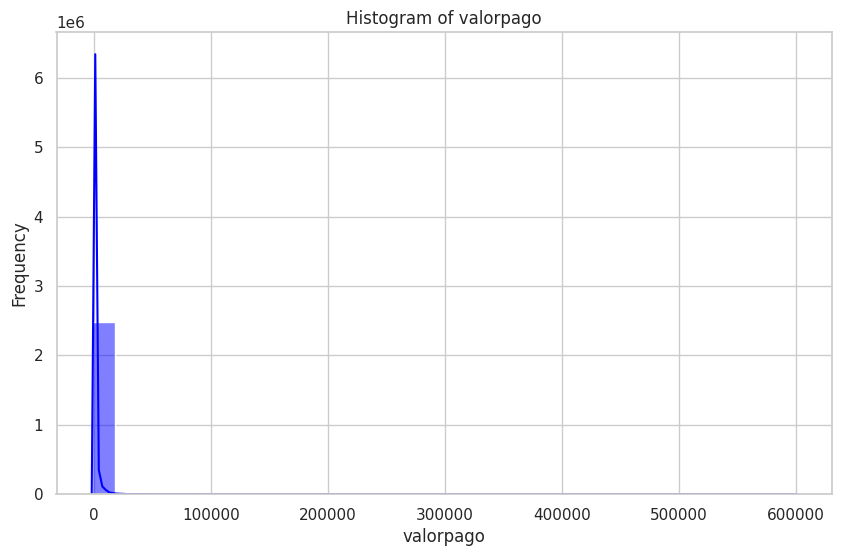

In [29]:
# Set up the style for the plot (optional)
sns.set(style='whitegrid')

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merge, x='valorpago', bins=30, kde=True, color='blue')

# Add title and labels
plt.title('Histogram of valorpago')
plt.xlabel('valorpago')
plt.ylabel('Frequency')

# Display the plot
plt.show()

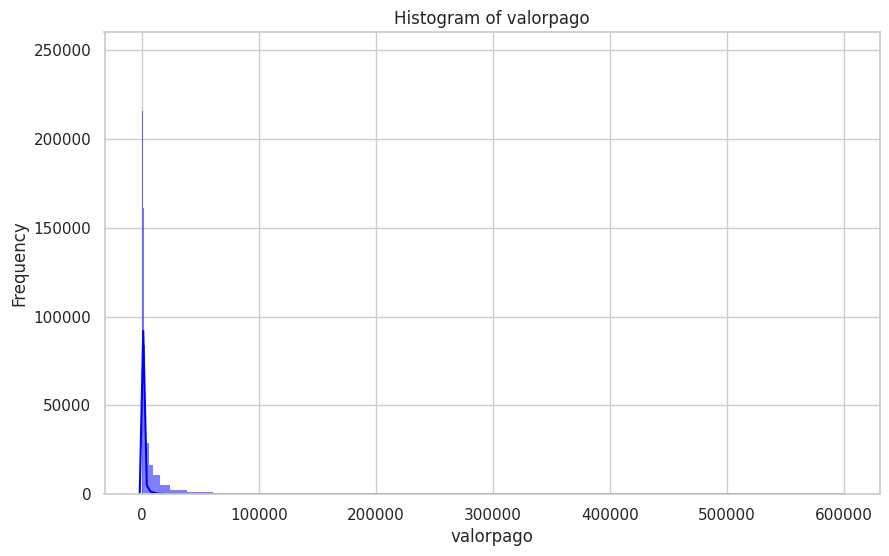

In [30]:
# Set up the style for the plot (optional)
sns.set(style='whitegrid')

# Create a histogram with logarithmic bins
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merge, x='valorpago', bins=10 ** np.linspace(np.log10(1), np.log10(df_merge['valorpago'].max()), 30), kde=True, color='blue')

# Add title and labels
plt.title('Histogram of valorpago')
plt.xlabel('valorpago')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [31]:
# Extract the 'valorpago' column as a numpy array
valorpago_data = df_merge['valorpago'].values

# Perform the Shapiro-Wilk test
shapiro_test_statistic, shapiro_p_value = stats.shapiro(valorpago_data)

# Set the significance level
alpha = 0.05

# Check the p-value against the significance level
if shapiro_p_value > alpha:
    print("The 'valorpago' data follows a normal distribution (fail to reject null hypothesis)")
else:
    print("The 'valorpago' data does not follow a normal distribution (reject null hypothesis)")

The 'valorpago' data does not follow a normal distribution (reject null hypothesis)


/usr/lib/python3/dist-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [32]:
# criando flag de outlier do zscore
df_merge['otlr_zscore'] = df_merge['zscore'].apply(lambda x: 1 if abs(x) > 3. else 0)
df_merge['qtd_lancamentos'] = 1
df_merge

,datapagamento,id,nome_unidade,categoria,subcategoria,valorpago,median,adiff,std,mean,mad,mod_zscore,zscore,otlr_mod_zscore,otlr_zscore,qtd_lancamentos
0,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Folha Mensal - Salário,1301.0,1100.00,201.00,670.518493,858.010662,400.000,0.338936,0.660667,0,0,1
1,2021-01-01,19566.0,AmorSaúde Araçatuba,Funcionários,Folha Mensal - Salário,300.0,1371.27,1071.27,765.824898,1493.034867,295.045,-2.449022,-1.557843,0,0,1
2,2021-01-01,19321.0,AmorSaúde Dourados,Despesas com Outros Profissionais,Despesas com Outros Profissionais,361.7,500.00,138.30,134.952688,411.340000,0.000,NaN,-0.367833,0,0,1
3,2021-01-01,19626.0,AmorSaúde Porto Velho,Funcionários,Vale Alimentação/Refeição,220.0,150.00,70.00,86.774278,134.480465,70.000,0.674500,0.985540,0,0,1
4,2021-01-01,19566.0,AmorSaúde Araçatuba,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,58.0,92.50,34.50,152.374588,133.658522,57.500,-0.404700,-0.496530,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485890,2023-08-22,19573.0,AmorSaúde João Pessoa Sul,Repasses,Repasse de Consultas,350.0,345.60,4.40,268.862492,390.566806,145.600,0.020383,-0.150883,0,0,1
2485891,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,200.0,400.00,200.00,450.906656,506.225464,350.000,-0.385429,-0.679133,0,0,1
2485892,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1225.0,400.00,825.00,450.906656,506.225464,350.000,1.589893,1.594065,0,0,1
2485893,2023-08-22,19608.0,AmorSaúde Itanhaém,Repasses,Repasse de Consultas,1645.0,400.00,1245.00,450.906656,506.225464,350.000,2.399293,2.525522,0,0,1


In [33]:
df_grouped = df_merge.groupby(['id', 'nome_unidade', 'categoria', 'subcategoria']).agg({
    'otlr_mod_zscore': 'sum',
    'otlr_zscore': 'sum',
    'qtd_lancamentos': 'sum'
}).reset_index()
#df_grouped = df_merge.groupby(['id', 'nome_unidade', 'categoria', 'subcategoria']).sum().reset_index()

df_grouped

,id,nome_unidade,categoria,subcategoria,otlr_mod_zscore,otlr_zscore,qtd_lancamentos
0,0.0,CENTRAL AMORSAÚDE,Funcionários,Vale Transporte,0,0,2
1,18263.0,AmorSaúde Carapicuíba,Administrativas,Advogados,0,0,1
2,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel Imóvel,32,2,100
3,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel de Equipamentos,0,0,90
4,18263.0,AmorSaúde Carapicuíba,Administrativas,Alvarás,0,0,26
...,...,...,...,...,...,...,...
33923,19990.0,AmorSaúde Piracicaba Vila Sônia,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,0,0,2
33924,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Consultas,0,0,64
33925,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Procedimentos,1,1,30
33926,19990.0,AmorSaúde Piracicaba Vila Sônia,Sócios,Transação Entre Contas Médica e Odonto,0,0,4


In [34]:
df_grouped_batatais = df_grouped.loc[df_grouped['id']==19957]
df_grouped_batatais = df_grouped_batatais.loc[df_grouped_batatais['subcategoria']=='Folha Mensal - Adiantamento']
df_grouped_batatais

,id,nome_unidade,categoria,subcategoria,otlr_mod_zscore,otlr_zscore,qtd_lancamentos
33250,19957.0,AmorSaúde Batatais,Funcionários,Folha Mensal - Adiantamento,15,0,31


In [35]:
df_grouped['pct_otlr_mod_zscore'] = (df_grouped['otlr_mod_zscore'] / df_grouped['qtd_lancamentos']).round(2)
df_grouped['pct_otlr_zscore'] = (df_grouped['otlr_zscore'] / df_grouped['qtd_lancamentos']).round(2)
df_grouped

,id,nome_unidade,categoria,subcategoria,otlr_mod_zscore,otlr_zscore,qtd_lancamentos,pct_otlr_mod_zscore,pct_otlr_zscore
0,0.0,CENTRAL AMORSAÚDE,Funcionários,Vale Transporte,0,0,2,0.00,0.00
1,18263.0,AmorSaúde Carapicuíba,Administrativas,Advogados,0,0,1,0.00,0.00
2,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel Imóvel,32,2,100,0.32,0.02
3,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel de Equipamentos,0,0,90,0.00,0.00
4,18263.0,AmorSaúde Carapicuíba,Administrativas,Alvarás,0,0,26,0.00,0.00
...,...,...,...,...,...,...,...,...,...
33923,19990.0,AmorSaúde Piracicaba Vila Sônia,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,0,0,2,0.00,0.00
33924,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Consultas,0,0,64,0.00,0.00
33925,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Procedimentos,1,1,30,0.03,0.03
33926,19990.0,AmorSaúde Piracicaba Vila Sônia,Sócios,Transação Entre Contas Médica e Odonto,0,0,4,0.00,0.00


In [36]:
# Define the columns to merge on
merge_cols = ['id', 'nome_unidade', 'categoria', 'subcategoria']

# Merge the DataFrames
df_otlr = pd.merge(df_grouped, grouped_iqr, on=merge_cols, how='left')

df_otlr

,id,nome_unidade,categoria,subcategoria,otlr_mod_zscore,otlr_zscore,qtd_lancamentos,pct_otlr_mod_zscore,pct_otlr_zscore,otlr_iqr,pct_otlr_iqr
0,0.0,CENTRAL AMORSAÚDE,Funcionários,Vale Transporte,0,0,2,0.00,0.00,0,0.000000
1,18263.0,AmorSaúde Carapicuíba,Administrativas,Advogados,0,0,1,0.00,0.00,0,0.000000
2,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel Imóvel,32,2,100,0.32,0.02,0,0.000000
3,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel de Equipamentos,0,0,90,0.00,0.00,0,0.000000
4,18263.0,AmorSaúde Carapicuíba,Administrativas,Alvarás,0,0,26,0.00,0.00,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
33923,19990.0,AmorSaúde Piracicaba Vila Sônia,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,0,0,2,0.00,0.00,0,0.000000
33924,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Consultas,0,0,64,0.00,0.00,7,0.109375
33925,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Procedimentos,1,1,30,0.03,0.03,2,0.066667
33926,19990.0,AmorSaúde Piracicaba Vila Sônia,Sócios,Transação Entre Contas Médica e Odonto,0,0,4,0.00,0.00,0,0.000000


In [37]:
columns_order = ['id', 'nome_unidade', 'categoria', 'subcategoria', 'qtd_lancamentos', 'otlr_iqr', 'otlr_zscore', 'otlr_mod_zscore', 'pct_otlr_iqr', 'pct_otlr_zscore', 'pct_otlr_mod_zscore']
df_otlr = df_otlr[columns_order]

In [38]:
df_otlr

,id,nome_unidade,categoria,subcategoria,qtd_lancamentos,otlr_iqr,otlr_zscore,otlr_mod_zscore,pct_otlr_iqr,pct_otlr_zscore,pct_otlr_mod_zscore
0,0.0,CENTRAL AMORSAÚDE,Funcionários,Vale Transporte,2,0,0,0,0.000000,0.00,0.00
1,18263.0,AmorSaúde Carapicuíba,Administrativas,Advogados,1,0,0,0,0.000000,0.00,0.00
2,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel Imóvel,100,0,2,32,0.000000,0.02,0.32
3,18263.0,AmorSaúde Carapicuíba,Administrativas,Aluguel de Equipamentos,90,0,0,0,0.000000,0.00,0.00
4,18263.0,AmorSaúde Carapicuíba,Administrativas,Alvarás,26,0,0,0,0.000000,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
33923,19990.0,AmorSaúde Piracicaba Vila Sônia,Outras Despesas,Ressarcimento de Exames e Procedimentos Médicos,2,0,0,0,0.000000,0.00,0.00
33924,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Consultas,64,7,0,0,0.109375,0.00,0.00
33925,19990.0,AmorSaúde Piracicaba Vila Sônia,Repasses,Repasse de Procedimentos,30,2,1,1,0.066667,0.03,0.03
33926,19990.0,AmorSaúde Piracicaba Vila Sônia,Sócios,Transação Entre Contas Médica e Odonto,4,0,0,0,0.000000,0.00,0.00


In [39]:
# Select only the necessary columns from df_iqr
df_iqr_subset = df_iqr[['datapagamento', 'id', 'nome_unidade', 'categoria', 'subcategoria', 'valorpago', 'lower_fence', 'upper_fence', 'otlr_iqr']]

# Merge the subsets of DataFrames
df_otlr_despesas = pd.merge(df_iqr_subset, df_merge, on=['datapagamento', 'id', 'nome_unidade', 'categoria', 'subcategoria', 'valorpago'], how='left')

#df_otlr_despesas = pd.merge(df_iqr, df_merge, on=['datapagamento','id', 'nome_unidade', 'categoria', 'subcategoria', 'valorpago'], how='left')
df_otlr_despesas

: 

: 

In [ ]:
# Assuming df_otlr_despesas is your DataFrame
desired_order = ['datapagamento', 'id', 'nome_unidade', 'categoria', 'subcategoria',
                 'valorpago', 'lower_fence', 'upper_fence', 'otlr_iqr', 'median',
                 'adiff', 'std', 'mean', 'mad', 'zscore', 'otlr_zscore', 'mod_zscore',
                 'otlr_mod_zscore', 'qtd_lancamentos']

df_otlr_despesas = df_otlr_despesas[desired_order]

In [ ]:
df_grouped.to_excel('validacao_df_agrupado.xlsx', index=False)

In [ ]:
df_otlr.to_excel('validacao_df_outliers.xlsx', index=False)

validações

In [ ]:
df_batatais = df_otlr_despesas.loc[df_otlr_despesas['id']==19957]
df_batatais.to_excel('validacao_despesas_batatais.xlsx', index=False)

In [ ]:
df_bhbarreiro = df_otlr_despesas.loc[df_otlr_despesas['id']==19543]
df_bhbarreiro.to_excel('validacao_despesas_bhbarreiro.xlsx', index=False)